# Requirements

In [1]:
# Standard library imports
import os
import random

# Scientific computing
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split, Subset
from torch.utils.tensorboard import SummaryWriter

# Computer Vision and Image Processing
from PIL import Image
from torchvision import models, transforms, datasets
from torchvision.datasets import ImageFolder

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Progress bar
from tqdm import tqdm


# Suppress warnings
import warnings

warnings.filterwarnings('ignore')

# JSON and datetime for logging
import json
from datetime import datetime

# Config 

- The `config` section defines all key hyperparameters and paths used throughout the notebook.
- It centralizes settings like data directory, image size, batch size, number of epochs, learning rate, class names, device selection (CPU/MPS), and data split ratio.
- Using a configuration class makes the code cleaner, easier to maintain, and ensures consistency across all functions and models.what is this config file in markdown in short and in points 

In [ ]:
# Configuration class for all hyperparameters and paths
class Config:
    DATA_DIR = '/Users/rishi/Desktop/Assignment/Data'  # Path to your dataset
    IMAGE_SIZE = (224, 224)                            # Image size for resizing
    BATCH_SIZE = 32                                    # Batch size for DataLoader
    EPOCHS = 50                                        # Number of training epochs
    LEARNING_RATE = 0.001                              # Initial learning rate
    CLASSES = ['None', 'back', 'front']                # List of class names
    NUM_CLASSES = len(CLASSES)                         # Number of classes
    DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")  # Use MPS if available, else CPU
    TRAIN_SPLIT = 0.8                                  # Train/validation split ratio
    NUM_WORKERS = 4                                    # Number of DataLoader workers

# Instantiate the configuration
config = Config()


# Data Preprocessing

- Loads the image dataset and extracts class labels for stratified splitting.
- Splits the dataset into training and validation sets while maintaining class proportions.
- Defines image transformations for data augmentation (training) and normalization (both sets).
- Applies the appropriate transforms to create train and validation datasets.
- Wraps datasets in DataLoader objects for efficient batch loading.
- Prints dataset statistics and verifies data loading.

In [ ]:
def load_initial_dataset():
    """Load the initial dataset to get labels for stratification"""
    # Load the full dataset using ImageFolder
    full_dataset = ImageFolder(config.DATA_DIR)
    # Extract labels for each sample (used for stratified splitting)
    labels = [label for _, label in full_dataset.samples]
    # Get the list of class names
    classes = full_dataset.classes

    # Print dataset statistics
    print(f"Total samples: {len(full_dataset)}")
    print(f"Number of classes: {len(classes)}")
    print("Classes:", classes)

    return full_dataset, labels, classes

In [ ]:
def create_stratified_split(full_dataset, labels):
    """Create stratified train-validation split"""
    # Get indices for all samples
    indices = np.arange(len(labels))
    
    # Perform stratified split to maintain class proportions in train/val sets
    train_indices, val_indices = train_test_split(
        indices,
        train_size=config.TRAIN_SPLIT,   # Proportion of data to use for training
        stratify=labels,                 # Stratify by class labels
        random_state=42                  # For reproducibility
    )
    
    return train_indices, val_indices

In [ ]:
def get_transforms():
    """Define training and validation transforms"""
    # Data augmentation and normalization for training
    train_transforms = transforms.Compose([
        transforms.RandomResizedCrop(
            config.IMAGE_SIZE,
            scale=(0.8, 1.0)  # Randomly crop and resize images
        ),
        transforms.RandomHorizontalFlip(),            # Randomly flip images horizontally
        transforms.RandomRotation(15),                # Randomly rotate images by up to 15 degrees
        transforms.ColorJitter(
            brightness=0.2,                           # Randomly change brightness
            contrast=0.2,                             # Randomly change contrast
            saturation=0.1,                           # Randomly change saturation
            hue=0.1                                   # Randomly change hue
        ),
        transforms.ToTensor(),                        # Convert PIL Image to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],              # Normalize with ImageNet mean
            std=[0.229, 0.224, 0.225]                # Normalize with ImageNet std
        )
    ])

    # Only resizing and normalization for validation
    val_transforms = transforms.Compose([
        transforms.Resize(config.IMAGE_SIZE),         # Resize image to target size
        transforms.CenterCrop(config.IMAGE_SIZE),     # Center crop to target size
        transforms.ToTensor(),                        # Convert PIL Image to tensor
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],              # Normalize with ImageNet mean
            std=[0.229, 0.224, 0.225]                # Normalize with ImageNet std
        )
    ])
    
    return train_transforms, val_transforms

In [ ]:
def create_datasets_with_transforms(train_indices, val_indices):
    """Create datasets with appropriate transforms"""
    # Get data augmentation and normalization transforms for train/val
    train_transforms, val_transforms = get_transforms()
    
    # Create ImageFolder datasets with transforms applied
    train_dataset = ImageFolder(
        root=config.DATA_DIR,
        transform=train_transforms
    )
    val_dataset = ImageFolder(
        root=config.DATA_DIR,
        transform=val_transforms
    )
    
    # Use Subset to select only the indices for train/val split
    train_dataset = Subset(train_dataset, train_indices)
    val_dataset = Subset(val_dataset, val_indices)
    
    return train_dataset, val_dataset


In [ ]:
def create_dataloaders(train_dataset, val_dataset):
    """Create train and validation dataloaders"""
    # DataLoader for training set (shuffling enabled)
    train_loader = DataLoader(
        train_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=True,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    
    # DataLoader for validation set (no shuffling)
    val_loader = DataLoader(
        val_dataset,
        batch_size=config.BATCH_SIZE,
        shuffle=False,
        num_workers=config.NUM_WORKERS,
        pin_memory=True
    )
    
    return train_loader, val_loader

In [ ]:
def print_dataset_stats(train_dataset, val_dataset, classes):
    """Print detailed dataset statistics"""
    print("\nDataset Statistics:")
    print(f"Total samples: {len(train_dataset) + len(val_dataset)}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    
    # Get class distribution for training and validation sets
    train_labels = [train_dataset.dataset.targets[idx] for idx in train_dataset.indices]
    val_labels = [val_dataset.dataset.targets[idx] for idx in val_dataset.indices]
    
    print("\nClass distribution:")
    print("Class\t\tTrain\tValidation\tRatio")
    print("-" * 50)
    
    # Print class-wise counts and train/val ratio
    for i, class_name in enumerate(classes):
        train_count = train_labels.count(i)
        val_count = val_labels.count(i)
        ratio = train_count / val_count if val_count > 0 else 0
        print(f"{class_name:<15} {train_count:>5} {val_count:>10} {ratio:>10.2f}")

In [ ]:
def verify_data_loading(train_loader, val_loader):
    """Verify data loading and shapes"""
    print("\nVerifying data loading:")
    
    # Check a batch from the training loader
    images, labels = next(iter(train_loader))
    print("\nTraining batch:")
    print(f"Image batch shape: {images.shape}")  # Shape of image batch (batch_size, channels, height, width)
    print(f"Labels batch shape: {labels.shape}")  # Shape of label batch (batch_size,)
    print(f"Images dtype: {images.dtype}")        # Data type of images (should be torch.float32)
    print(f"Labels unique values: {torch.unique(labels)}")  # Unique class labels in the batch
    
    # Check a batch from the validation loader
    images, labels = next(iter(val_loader))
    print("\nValidation batch:")
    print(f"Image batch shape: {images.shape}")   # Shape of image batch (batch_size, channels, height, width)
    print(f"Labels batch shape: {labels.shape}")  # Shape of label batch (batch_size,)
    print(f"Images dtype: {images.dtype}")        # Data type of images (should be torch.float32)
    print(f"Labels unique values: {torch.unique(labels)}")  # Unique class labels in the batch

# Load the Data

In [10]:
# Load initial dataset and extract labels/classes for stratified splitting
full_dataset, labels, classes = load_initial_dataset()

# Create stratified train/validation split indices
train_indices, val_indices = create_stratified_split(full_dataset, labels)

# Create training and validation datasets with appropriate transforms
train_dataset, val_dataset = create_datasets_with_transforms(
    train_indices, 
    val_indices
)

# Create DataLoader objects for training and validation sets
train_loader, val_loader = create_dataloaders(train_dataset, val_dataset)

# Print dataset statistics (sample counts, class distribution, etc.)
print_dataset_stats(train_dataset, val_dataset, classes)

# Verify that data loading works and check batch shapes/types
verify_data_loading(train_loader, val_loader)


Total samples: 298
Number of classes: 3
Classes: ['None', 'back', 'front']

Dataset Statistics:
Total samples: 298
Training samples: 238
Validation samples: 60

Class distribution:
Class		Train	Validation	Ratio
--------------------------------------------------
None               61         15       4.07
back               96         25       3.84
front              81         20       4.05

Verifying data loading:

Training batch:
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Images dtype: torch.float32
Labels unique values: tensor([0, 1, 2])

Validation batch:
Image batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: torch.Size([32])
Images dtype: torch.float32
Labels unique values: tensor([0, 1, 2])


# Visualise Dataset 

- Shows random sample images from each class in both training and validation datasets.
- Helps visually inspect data quality, class balance, and preprocessing effects.
- Uses denormalization to display images in natural colors.
- Useful for verifying correct data loading and augmentation.

In [ ]:
def denormalize_image(image):
    """Denormalize the image tensor for visualization (undo normalization)."""
    mean = torch.tensor([0.485, 0.456, 0.406]).reshape(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).reshape(3, 1, 1)
    return image * std + mean

def display_samples(dataset, classes, samples_per_class=5, title=""):
    """
    Display sample images for each class from a dataset.

    Args:
        dataset: PyTorch dataset or Subset.
        classes: List of class names.
        samples_per_class: Number of images to display per class.
        title: Title for the plot.
    """
    fig = plt.figure(figsize=(12, 4 * len(classes)))
    
    for class_idx, class_name in enumerate(classes):
        # Get indices for this class
        if hasattr(dataset, 'indices'):
            # For Subset datasets, map indices to original targets
            class_indices = [i for i, idx in enumerate(dataset.indices) 
                             if dataset.dataset.targets[idx] == class_idx]
        else:
            # For regular datasets
            class_indices = [i for i, (_, label) in enumerate(dataset) 
                             if label == class_idx]
        
        # Randomly sample images from this class
        sample_indices = np.random.choice(
            class_indices, 
            min(samples_per_class, len(class_indices)), 
            replace=False
        )
        
        # Display images for this class
        for i, idx in enumerate(sample_indices):
            img, _ = dataset[idx]
            img = denormalize_image(img)  # Undo normalization for display
            
            plt.subplot(len(classes), samples_per_class, 
                        class_idx * samples_per_class + i + 1)
            
            # Convert tensor to numpy and adjust shape for imshow
            img = img.numpy().transpose(1, 2, 0)
            img = np.clip(img, 0, 1)  # Ensure values are in [0, 1]
            
            plt.imshow(img)
            if i == 0:  # Show class name only for first image in row
                plt.title(f'{class_name}')
            plt.axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


Training Samples:


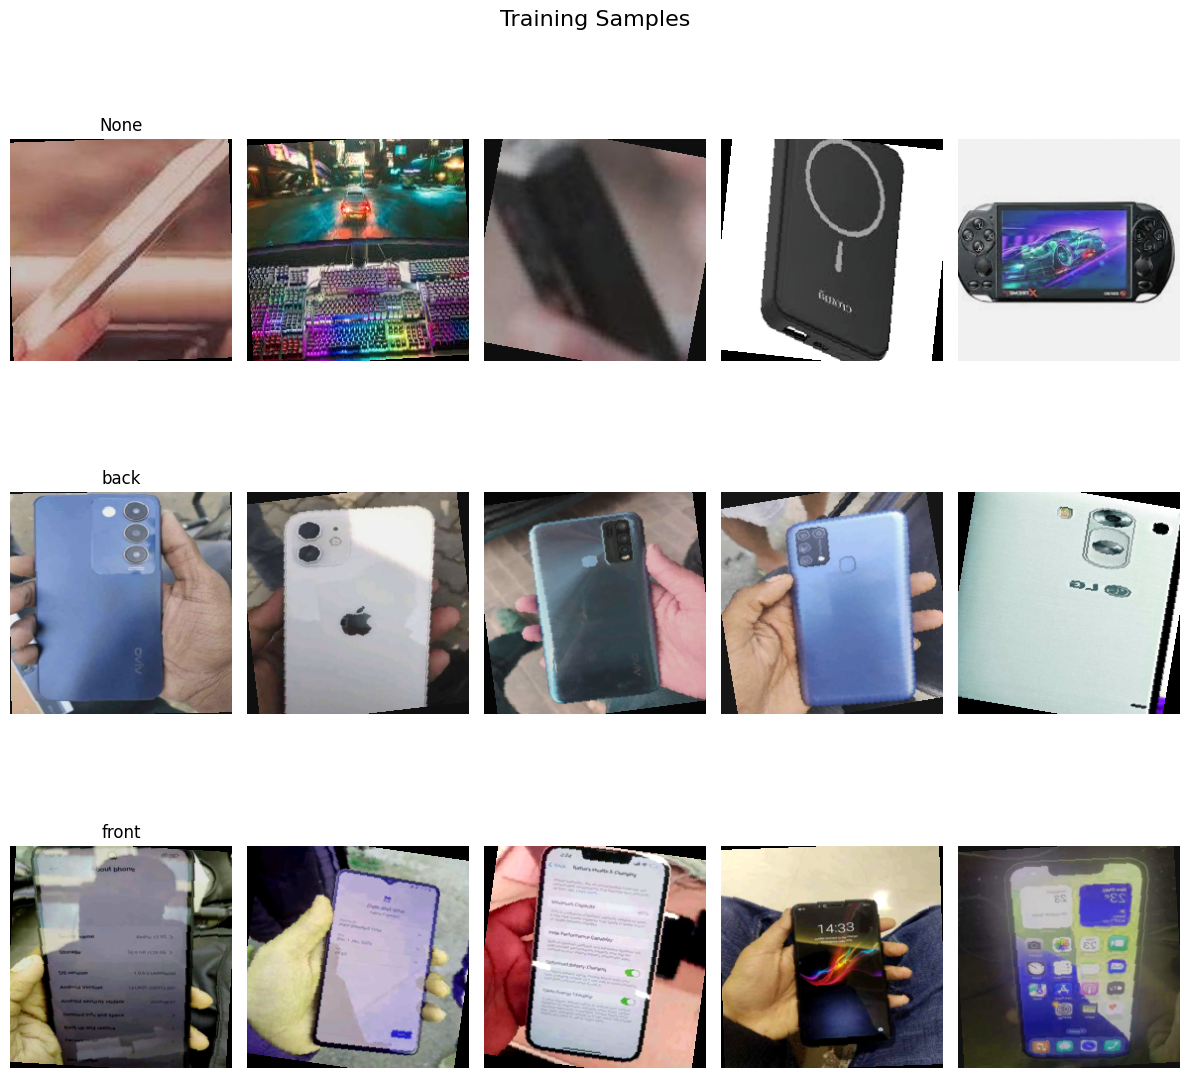


Validation Samples:


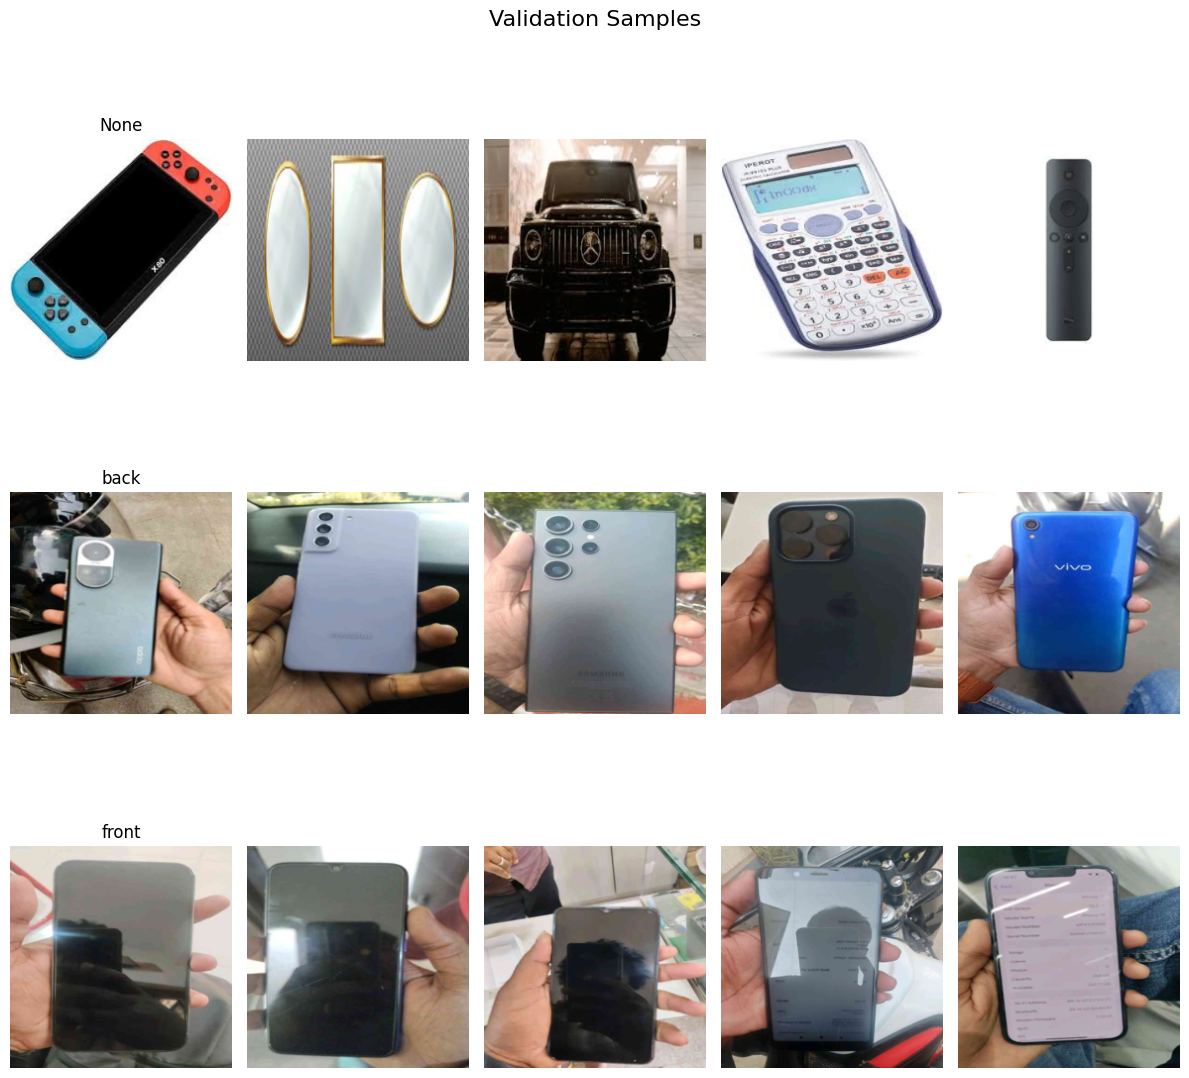

In [12]:
"""Show samples from both training and validation sets"""
print("Training Samples:")
display_samples(train_dataset, classes, title="Training Samples")

print("\nValidation Samples:")
display_samples(val_dataset, classes, title="Validation Samples")

# Model Architecture

- The architecture is a custom fine-tuned MobileNetV2 and Resnet50 model for image classification.
- Uses a pretrained MobileNetV2 and Resnet50 as the feature extractor (base_model).
- Early layers of the base model are frozen; only the last few layers are trainable for fine-tuning.
- The original classifier is replaced with a custom head:
    - Adaptive average pooling and flattening.
    - Three fully connected (Linear) layers with BatchNorm, PReLU activation, and Dropout for regularization.
    - Final output layer matches the number of target classes.
- Designed to improve performance and generalization on the specific dataset.

In [ ]:
class ResNet50Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(ResNet50Custom, self).__init__()
        # Load pretrained ResNet50 as the base model
        self.base_model = models.resnet50(pretrained=True)
        
        # Freeze early layers to retain pretrained features
        for param in list(self.base_model.parameters())[:-6]:
            param.requires_grad = False
        # Unfreeze last 6 layers for fine-tuning
        for param in list(self.base_model.parameters())[-6:]:
            param.requires_grad = True
            
        # Remove the original fully connected classifier
        num_ftrs = self.base_model.fc.in_features
        self.base_model.fc = nn.Identity()
        
        # Custom classifier head with batch norm, PReLU, and dropout
        self.custom_classifier = nn.Sequential(
            nn.Linear(num_ftrs, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        # Forward through base model (feature extractor)
        x = self.base_model(x)
        # Forward through custom classifier head
        x = self.custom_classifier(x)
        return x

In [ ]:
class MobileNetV2Custom(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(MobileNetV2Custom, self).__init__()
        # Load pretrained MobileNetV2 as the base model
        self.base_model = models.mobilenet_v2(pretrained=True)
        
        # Freeze early layers, unfreeze last 8 layers for fine-tuning
        for param in list(self.base_model.parameters())[:-8]:
            param.requires_grad = False
        for param in list(self.base_model.parameters())[-8:]:
            param.requires_grad = True
        
        # Get the number of output features from the base model
        num_ftrs = self.base_model.last_channel
        
        # Custom classifier head with batch norm, PReLU, and dropout
        self.custom_classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),  # Global average pooling
            nn.Flatten(),             # Flatten to (batch, features)
            
            nn.Linear(num_ftrs, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(dropout_rate),
            
            nn.Linear(256, num_classes)  # Output layer
        )
        
    def forward(self, x):
        # Forward through base model's feature extractor
        x = self.base_model.features(x)
        # Forward through custom classifier head
        x = self.custom_classifier(x)
        return x

# Hyperparameter 

- Contains utility functions for model training setup and handling class imbalance.
- `get_class_weights`: Calculates class weights based on training data to address class imbalance.
- `FocalLoss`: Custom loss function that focuses on hard-to-classify examples, useful for imbalanced datasets.
- `setup_model`: Prepares the model, loss function, optimizer, and learning rate scheduler for training.

In [ ]:
def get_class_weights(train_dataset):
    """
    Calculate class weights for imbalanced dataset.
    Returns a tensor of weights inversely proportional to class frequencies.
    """
    # Extract labels from the dataset (handles both Subset and regular datasets)
    if hasattr(train_dataset, 'indices'):
        labels = [train_dataset.dataset.targets[idx] for idx in train_dataset.indices]
    else:
        labels = train_dataset.targets

    # Count number of samples per class
    class_counts = torch.bincount(torch.tensor(labels))
    total_samples = len(labels)

    # Compute weights: inverse frequency for each class
    weights = total_samples / (len(class_counts) * class_counts.float())
    return weights

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss for addressing class imbalance by focusing on hard examples.

        Args:
            weight (Tensor, optional): Class weights for balancing.
            gamma (float): Focusing parameter for modulating factor (1-pt).
            reduction (str): Specifies the reduction to apply to the output: 'mean', 'sum', or 'none'.
        """
        super(FocalLoss, self).__init__()
        self.weight = weight
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, input, target):
        """
        Compute the focal loss between input logits and target labels.

        Args:
            input (Tensor): Predicted logits (batch_size, num_classes).
            target (Tensor): Ground truth labels (batch_size).

        Returns:
            Tensor: Computed focal loss.
        """
        # Compute standard cross entropy loss (no reduction)
        ce_loss = F.cross_entropy(input, target, weight=self.weight, reduction='none')
        # Compute pt (probability of the true class)
        pt = torch.exp(-ce_loss)
        # Apply focal loss formula
        focal_loss = ((1 - pt) ** self.gamma * ce_loss)
        
        # Apply reduction method
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        return focal_loss

In [ ]:
def setup_model(model, train_dataset, weight_decay=0.01):
    """
    Setup model with appropriate loss function and optimizer
    
    Args:
        model: Pre-initialized PyTorch model
        train_dataset: Training dataset for calculating class weights
        weight_decay: Weight decay for optimizer (default: 0.01)
    
    Returns:
        tuple: (model, criterion, optimizer, scheduler)
    """
    # Move model to the correct device (CPU, CUDA, or MPS)
    model = model.to(config.DEVICE)
    
    # Calculate class weights for imbalanced datasets
    class_weights = get_class_weights(train_dataset).to(config.DEVICE)
    
    # Use FocalLoss with class weights to handle class imbalance
    criterion = FocalLoss(weight=class_weights)
    
    # Set up optimizer with different learning rates for base and custom classifier
    try:
        params = [
            # Lower learning rate for pretrained base model
            {'params': model.base_model.parameters(), 'lr': config.LEARNING_RATE * 0.1},
            # Higher learning rate for custom classifier layers
            {'params': model.custom_classifier.parameters(), 'lr': config.LEARNING_RATE}
        ]
    except AttributeError:
        # Fallback: use a single learning rate if model structure is different
        params = model.parameters()
    
    optimizer = torch.optim.AdamW(params, weight_decay=weight_decay)
    
    # Learning rate scheduler: reduce LR on plateau of validation loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 
        mode='min', 
        factor=0.1, 
        patience=3
    )
    
    return model, criterion, optimizer, scheduler

# Training Loop

- Implements the main training loop for the model with early stopping and checkpointing.
- Tracks and logs training/validation loss, accuracy, and learning rate for each epoch.
- Saves the best model based on validation loss and stores training metrics to disk.
- Supports resuming, error handling, and provides a summary after training completes.

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, 
                num_epochs=30, device='cuda', patience=5, tolerance=1e-6, 
                save_dir='training_runs', run_name=None):
    """
    Train a model with early stopping, comprehensive logging, and checkpointing.
    """
    
    # Create run name if not provided
    if run_name is None:
        run_name = f"run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
    
    # Create directory structure for saving outputs
    base_dir = os.path.join(save_dir, run_name)
    model_dir = os.path.join(base_dir, 'models')
    metrics_dir = os.path.join(base_dir, 'metrics')
    status_dir = os.path.join(base_dir, 'status')
    
    # Create all directories if they don't exist
    os.makedirs(model_dir, exist_ok=True)
    os.makedirs(metrics_dir, exist_ok=True)
    os.makedirs(status_dir, exist_ok=True)
    
    # Define file paths for saving model, metrics, and status
    model_save_path = os.path.join(model_dir, 'best_model.pth')
    metrics_file_path = os.path.join(metrics_dir, 'training_metrics.json')
    status_file_path = os.path.join(status_dir, 'training_status.json')
    
    # Initialize dictionary to store training metrics
    training_metrics = {
        'train_losses': [],
        'val_losses': [],
        'train_accuracies': [],
        'val_accuracies': [],
        'learning_rates': [],
        'start_time': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'best_val_loss': float('inf'),
        'best_epoch': 0,
        'early_stopping_epoch': None,
        'model_save_path': model_save_path,
        'run_name': run_name,
        'save_directory': base_dir,
        'early_stopping_settings': {
            'patience': patience,
            'tolerance': tolerance
        }
    }
    
    # Initialize dictionary to track training status
    status = {
        'current_epoch': 0,
        'total_epochs': num_epochs,
        'status': 'starting',
        'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
        'progress_percentage': 0.0,
        'early_stopping': {
            'counter': 0,
            'best_val_loss': float('inf'),
            'patience': patience,
            'tolerance': tolerance,
            'epochs_without_improvement': 0
        }
    }
    
    # Save initial status to file
    with open(status_file_path, 'w') as f:
        json.dump(status, f, indent=4)
    
    # Early stopping variables
    counter = 0
    best_val_loss = float('inf')
    
    print(f"Training started. Files will be saved to: {base_dir}")
    print(f"Early stopping settings - Patience: {patience}, Tolerance: {tolerance}")
    
    try:
        for epoch in range(num_epochs):
            # Training Phase
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            # Iterate over training batches
            for inputs, targets in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
                inputs, targets = inputs.to(device), targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                train_total += targets.size(0)
                train_correct += (predicted == targets).sum().item()
            
            # Calculate average training loss and accuracy
            train_loss = train_loss / len(train_loader)
            train_accuracy = 100 * train_correct / train_total
            
            # Validation Phase
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            # Iterate over validation batches
            with torch.no_grad():
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item()
                    
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += targets.size(0)
                    val_correct += (predicted == targets).sum().item()
            
            # Calculate average validation loss and accuracy
            val_loss = val_loss / len(val_loader)
            val_accuracy = 100 * val_correct / val_total
            
            # Store metrics for this epoch
            training_metrics['train_losses'].append(train_loss)
            training_metrics['val_losses'].append(val_loss)
            training_metrics['train_accuracies'].append(train_accuracy)
            training_metrics['val_accuracies'].append(val_accuracy)
            training_metrics['learning_rates'].append(optimizer.param_groups[0]['lr'])
            
            # Update learning rate scheduler if provided
            if scheduler:
                scheduler.step(val_loss)
            
            # Early stopping check with tolerance
            if val_loss < (best_val_loss - tolerance):
                best_val_loss = val_loss
                counter = 0
                
                # Save best model checkpoint
                checkpoint = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                    'val_loss': val_loss,
                    'val_accuracy': val_accuracy,
                    'train_loss': train_loss,
                    'train_accuracy': train_accuracy
                }
                torch.save(checkpoint, model_save_path)
                
                # Update best metrics
                training_metrics['best_val_loss'] = val_loss
                training_metrics['best_epoch'] = epoch + 1
                
                print(f'New best model saved at epoch {epoch + 1} with validation loss: {val_loss:.4f}')
            else:
                counter += 1
                if counter >= patience:
                    print(f'Early stopping triggered after {epoch + 1} epochs')
                    training_metrics['early_stopping_epoch'] = epoch + 1
                    break
            
            # Update status dictionary
            status.update({
                'current_epoch': epoch + 1,
                'current_train_loss': train_loss,
                'current_train_accuracy': train_accuracy,
                'current_val_loss': val_loss,
                'current_val_accuracy': val_accuracy,
                'current_lr': optimizer.param_groups[0]['lr'],
                'progress_percentage': ((epoch + 1) / num_epochs) * 100,
                'last_updated': datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
                'early_stopping': {
                    'counter': counter,
                    'best_val_loss': best_val_loss,
                    'patience': patience,
                    'tolerance': tolerance,
                    'epochs_without_improvement': counter
                }
            })
            
            # Save current status and metrics to files
            with open(status_file_path, 'w') as f:
                json.dump(status, f, indent=4)
            with open(metrics_file_path, 'w') as f:
                json.dump(training_metrics, f, indent=4)
            
            # Print epoch summary
            print(f'\nEpoch {epoch+1}/{num_epochs}:')
            print(f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%')
            print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
            print(f'Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')
            print(f'Early Stopping Counter: {counter}/{patience}')
            print('-' * 50)
    
    except Exception as e:
        # Handle exceptions during training
        print(f"Error during training: {str(e)}")
        status['status'] = 'failed'
        status['error'] = str(e)
    
    finally:
        # Final updates after training loop
        end_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        final_status = 'early_stopped' if counter >= patience else 'completed'
        
        # Update final metrics and status
        training_metrics['end_time'] = end_time
        training_metrics['final_status'] = final_status
        
        status.update({
            'status': final_status,
            'last_updated': end_time,
            'training_completed': True,
            'final_metrics': {
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'best_val_loss': best_val_loss,
                'best_epoch': training_metrics['best_epoch']
            }
        })
        
        # Save final metrics and status to files
        with open(metrics_file_path, 'w') as f:
            json.dump(training_metrics, f, indent=4)
        with open(status_file_path, 'w') as f:
            json.dump(status, f, indent=4)
        
        # Save final checkpoint with model and training info
        final_checkpoint_path = os.path.join(model_dir, 'final_checkpoint.pth')
        torch.save({
            'model_class': model.__class__.__name__,  # Save model class name
            'model_params': {  # Save model parameters
                'num_classes': config.NUM_CLASSES,  # Example parameter
                # Add other model initialization parameters here
            },
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
            'training_metrics': training_metrics,
            'status': status
        }, final_checkpoint_path)
        
        # (NEW) Load best model weights before returning
        if os.path.exists(model_save_path):
            checkpoint = torch.load(model_save_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            print(f"\n[INFO] Loaded best model weights from epoch {checkpoint['epoch']}, val loss = {checkpoint['val_loss']:.4f}")
        else:
            print("[WARNING] best_model.pth not found, returning model with final training weights.")
        
        # Print completion summary
        print('\nTraining Summary:')
        print(f'Status: {final_status}')
        print(f'Total Epochs Trained: {epoch + 1}')
        print(f'Best Validation Loss: {best_val_loss:.6f} (Epoch {training_metrics["best_epoch"]})')
        print(f'Final Validation Loss: {val_loss:.6f}')
        print(f'\nFiles saved to: {base_dir}')
        print(f'- Best model: {model_save_path}')
        print(f'- Final checkpoint: {final_checkpoint_path}')
        print(f'- Training metrics: {metrics_file_path}')
        print(f'- Training status: {status_file_path}')
    
    return training_metrics, model


# Plot the graph

- The `plot_metrics` function visualizes training and validation loss and accuracy over epochs.
- It saves the plots as image files in a specified directory.
- Displays the best epoch and early stopping points on the plots.
- Also plots the learning rate schedule during training.
- Helps to analyze model performance and training dynamics.

In [ ]:
def plot_metrics(training_metrics, save_dir):
    """
    Plot training and validation metrics from a completed training run.
    Displays plots in the notebook and saves them to disk.
    
    Args:
        training_metrics (dict): Dictionary containing training history
        save_dir (str): Directory where to save the plots
    """
    # Create figures directory
    figures_dir = os.path.join(save_dir, 'figures')
    os.makedirs(figures_dir, exist_ok=True)
    
    # Set basic plotting style
    plt.style.use('default')
    
    # Create two subplots for loss and accuracy
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Prepare epoch range
    epochs = range(1, len(training_metrics['train_losses']) + 1)
    
    # Plot training and validation loss
    ax1.plot(epochs, training_metrics['train_losses'], 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, training_metrics['val_losses'], 'r-', label='Validation Loss', linewidth=2)
    
    # Add vertical line for best epoch if available
    if 'best_epoch' in training_metrics:
        best_epoch = training_metrics['best_epoch']
        ax1.axvline(x=best_epoch, color='g', linestyle='--', 
                    label=f'Best Model (Epoch {best_epoch})')
    
    # Add early stopping line if applicable
    if training_metrics.get('early_stopping_epoch'):
        early_stop = training_metrics['early_stopping_epoch']
        ax1.axvline(x=early_stop, color='r', linestyle='--', 
                    label=f'Early Stopping (Epoch {early_stop})')
    
    # Set loss plot labels and grid
    ax1.set_title('Training and Validation Loss', fontsize=12, pad=10)
    ax1.set_xlabel('Epoch', fontsize=10)
    ax1.set_ylabel('Loss', fontsize=10)
    ax1.legend(fontsize=8)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Plot training and validation accuracy
    ax2.plot(epochs, training_metrics['train_accuracies'], 'b-', 
             label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, training_metrics['val_accuracies'], 'r-', 
             label='Validation Accuracy', linewidth=2)
    
    # Add vertical line for best epoch if available
    if 'best_epoch' in training_metrics:
        ax2.axvline(x=best_epoch, color='g', linestyle='--', 
                    label=f'Best Model (Epoch {best_epoch})')
    
    # Add early stopping line if applicable
    if training_metrics.get('early_stopping_epoch'):
        ax2.axvline(x=early_stop, color='r', linestyle='--', 
                    label=f'Early Stopping (Epoch {early_stop})')
    
    # Set accuracy plot labels and grid
    ax2.set_title('Training and Validation Accuracy', fontsize=12, pad=10)
    ax2.set_xlabel('Epoch', fontsize=10)
    ax2.set_ylabel('Accuracy (%)', fontsize=10)
    ax2.legend(fontsize=8)
    ax2.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    
    # Save and display training metrics plot
    plot_path = os.path.join(figures_dir, 'training_metrics.png')
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Create and display learning rate plot
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, training_metrics['learning_rates'], 'g-', label='Learning Rate', linewidth=2)
    plt.title('Learning Rate over Epochs', fontsize=12, pad=10)
    plt.xlabel('Epoch', fontsize=10)
    plt.ylabel('Learning Rate', fontsize=10)
    plt.yscale('log')  # Use log scale for learning rate
    plt.legend(fontsize=8)
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Save and display learning rate plot
    lr_plot_path = os.path.join(figures_dir, 'learning_rate.png')
    plt.savefig(lr_plot_path, dpi=300, bbox_inches='tight')
    plt.show()  # Display the plot
    
    # Print summary of training metrics
    print("\nTraining Metrics Summary:")
    print(f"Number of epochs trained: {len(epochs)}")
    print(f"Best validation loss: {min(training_metrics['val_losses']):.4f} "
          f"(Epoch {training_metrics['best_epoch']})")
    print(f"Final validation loss: {training_metrics['val_losses'][-1]:.4f}")
    print(f"Best validation accuracy: {max(training_metrics['val_accuracies']):.2f}%")
    print(f"Final validation accuracy: {training_metrics['val_accuracies'][-1]:.2f}%")
    print(f"\nPlots saved in: {figures_dir}")
    print(f"- Training metrics plot: {plot_path}")
    print(f"- Learning rate plot: {lr_plot_path}")

# Custom Resnet Fine-Tuning

In [20]:
# Setup model with custom architecture and training dataset
# resnet50_model
model_1, criterion_1, optimizer_1, scheduler_1 = setup_model(
model= ResNet50Custom(num_classes=config.NUM_CLASSES),
train_dataset=train_dataset
)

In [ ]:
# model layer summary
print(model_1)

ResNet50Custom(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(


In [21]:
metric_1,model_resnet = train_model(model_1, train_loader, val_loader, criterion_1, optimizer_1, scheduler_1,
        num_epochs=config.EPOCHS, device=config.DEVICE,
        save_dir="resnet_model", 
        run_name="resnet50_custom_run_1")

Training started. Files will be saved to: resnet_model/resnet50_custom_run_1
Early stopping settings - Patience: 5, Tolerance: 1e-06


Epoch 1/50: 100%|██████████| 8/8 [00:24<00:00,  3.06s/it]


New best model saved at epoch 1 with validation loss: 0.4238

Epoch 1/50:
Training Loss: 0.3623, Training Accuracy: 65.97%
Validation Loss: 0.4238, Validation Accuracy: 65.00%
Learning Rate: 0.000100
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 2/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


New best model saved at epoch 2 with validation loss: 0.0520

Epoch 2/50:
Training Loss: 0.1640, Training Accuracy: 80.67%
Validation Loss: 0.0520, Validation Accuracy: 91.67%
Learning Rate: 0.000100
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 3/50: 100%|██████████| 8/8 [00:21<00:00,  2.75s/it]



Epoch 3/50:
Training Loss: 0.1336, Training Accuracy: 90.76%
Validation Loss: 0.0663, Validation Accuracy: 90.00%
Learning Rate: 0.000100
Early Stopping Counter: 1/5
--------------------------------------------------


Epoch 4/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]



Epoch 4/50:
Training Loss: 0.1437, Training Accuracy: 90.34%
Validation Loss: 0.0840, Validation Accuracy: 86.67%
Learning Rate: 0.000100
Early Stopping Counter: 2/5
--------------------------------------------------


Epoch 5/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]



Epoch 5/50:
Training Loss: 0.1109, Training Accuracy: 88.66%
Validation Loss: 0.0961, Validation Accuracy: 90.00%
Learning Rate: 0.000100
Early Stopping Counter: 3/5
--------------------------------------------------


Epoch 6/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


New best model saved at epoch 6 with validation loss: 0.0245

Epoch 6/50:
Training Loss: 0.0640, Training Accuracy: 92.02%
Validation Loss: 0.0245, Validation Accuracy: 96.67%
Learning Rate: 0.000100
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 7/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]



Epoch 7/50:
Training Loss: 0.0765, Training Accuracy: 93.28%
Validation Loss: 0.0282, Validation Accuracy: 98.33%
Learning Rate: 0.000100
Early Stopping Counter: 1/5
--------------------------------------------------


Epoch 8/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]



Epoch 8/50:
Training Loss: 0.0390, Training Accuracy: 95.38%
Validation Loss: 0.0245, Validation Accuracy: 96.67%
Learning Rate: 0.000100
Early Stopping Counter: 2/5
--------------------------------------------------


Epoch 9/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]



Epoch 9/50:
Training Loss: 0.0400, Training Accuracy: 94.96%
Validation Loss: 0.0265, Validation Accuracy: 96.67%
Learning Rate: 0.000100
Early Stopping Counter: 3/5
--------------------------------------------------


Epoch 10/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]



Epoch 10/50:
Training Loss: 0.0384, Training Accuracy: 96.22%
Validation Loss: 0.0266, Validation Accuracy: 96.67%
Learning Rate: 0.000010
Early Stopping Counter: 4/5
--------------------------------------------------


Epoch 11/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


New best model saved at epoch 11 with validation loss: 0.0228

Epoch 11/50:
Training Loss: 0.0394, Training Accuracy: 94.54%
Validation Loss: 0.0228, Validation Accuracy: 96.67%
Learning Rate: 0.000010
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 12/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


New best model saved at epoch 12 with validation loss: 0.0223

Epoch 12/50:
Training Loss: 0.0227, Training Accuracy: 97.90%
Validation Loss: 0.0223, Validation Accuracy: 96.67%
Learning Rate: 0.000010
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 13/50: 100%|██████████| 8/8 [00:21<00:00,  2.75s/it]


New best model saved at epoch 13 with validation loss: 0.0190

Epoch 13/50:
Training Loss: 0.0680, Training Accuracy: 94.12%
Validation Loss: 0.0190, Validation Accuracy: 98.33%
Learning Rate: 0.000010
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 14/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


New best model saved at epoch 14 with validation loss: 0.0182

Epoch 14/50:
Training Loss: 0.0391, Training Accuracy: 95.38%
Validation Loss: 0.0182, Validation Accuracy: 98.33%
Learning Rate: 0.000010
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 15/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]


New best model saved at epoch 15 with validation loss: 0.0170

Epoch 15/50:
Training Loss: 0.0219, Training Accuracy: 97.48%
Validation Loss: 0.0170, Validation Accuracy: 98.33%
Learning Rate: 0.000010
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 16/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]



Epoch 16/50:
Training Loss: 0.0281, Training Accuracy: 97.06%
Validation Loss: 0.0171, Validation Accuracy: 98.33%
Learning Rate: 0.000010
Early Stopping Counter: 1/5
--------------------------------------------------


Epoch 17/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]


New best model saved at epoch 17 with validation loss: 0.0162

Epoch 17/50:
Training Loss: 0.0286, Training Accuracy: 97.06%
Validation Loss: 0.0162, Validation Accuracy: 98.33%
Learning Rate: 0.000010
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 18/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]



Epoch 18/50:
Training Loss: 0.0360, Training Accuracy: 96.22%
Validation Loss: 0.0183, Validation Accuracy: 98.33%
Learning Rate: 0.000010
Early Stopping Counter: 1/5
--------------------------------------------------


Epoch 19/50: 100%|██████████| 8/8 [00:22<00:00,  2.75s/it]



Epoch 19/50:
Training Loss: 0.0354, Training Accuracy: 97.06%
Validation Loss: 0.0206, Validation Accuracy: 96.67%
Learning Rate: 0.000010
Early Stopping Counter: 2/5
--------------------------------------------------


Epoch 20/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]



Epoch 20/50:
Training Loss: 0.0183, Training Accuracy: 98.32%
Validation Loss: 0.0214, Validation Accuracy: 96.67%
Learning Rate: 0.000010
Early Stopping Counter: 3/5
--------------------------------------------------


Epoch 21/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]



Epoch 21/50:
Training Loss: 0.0508, Training Accuracy: 97.06%
Validation Loss: 0.0220, Validation Accuracy: 96.67%
Learning Rate: 0.000001
Early Stopping Counter: 4/5
--------------------------------------------------


Epoch 22/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]


Early stopping triggered after 22 epochs

[INFO] Loaded best model weights from epoch 17, val loss = 0.0162

Training Summary:
Status: early_stopped
Total Epochs Trained: 22
Best Validation Loss: 0.016164 (Epoch 17)
Final Validation Loss: 0.019264

Files saved to: resnet_model/resnet50_custom_run_1
- Best model: resnet_model/resnet50_custom_run_1/models/best_model.pth
- Final checkpoint: resnet_model/resnet50_custom_run_1/models/final_checkpoint.pth
- Training metrics: resnet_model/resnet50_custom_run_1/metrics/training_metrics.json
- Training status: resnet_model/resnet50_custom_run_1/status/training_status.json


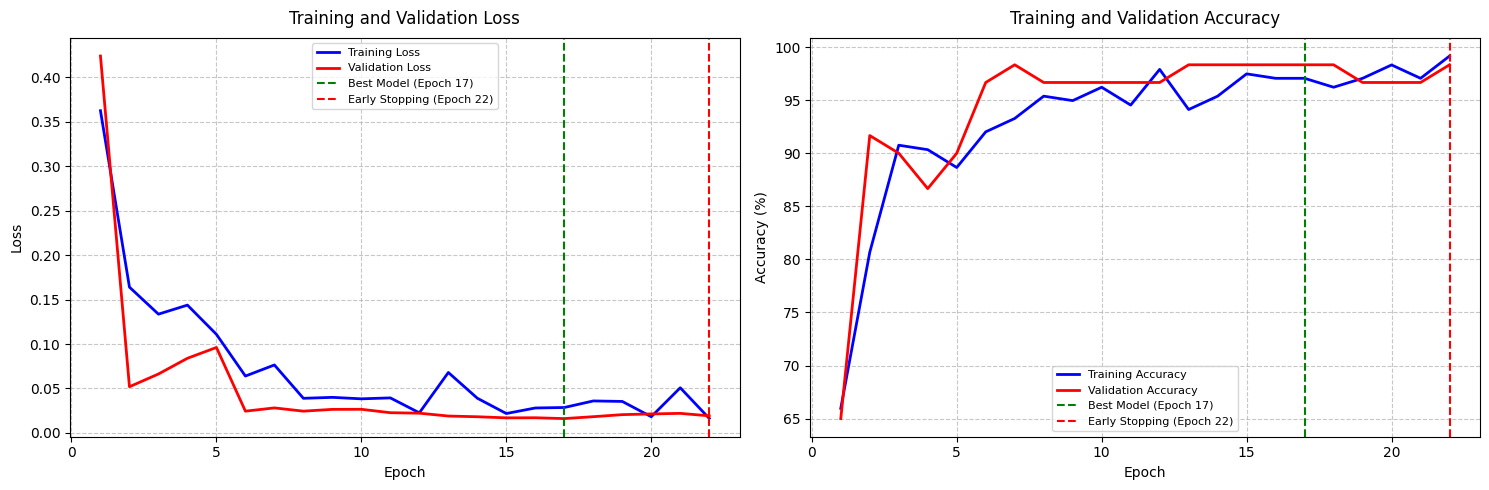

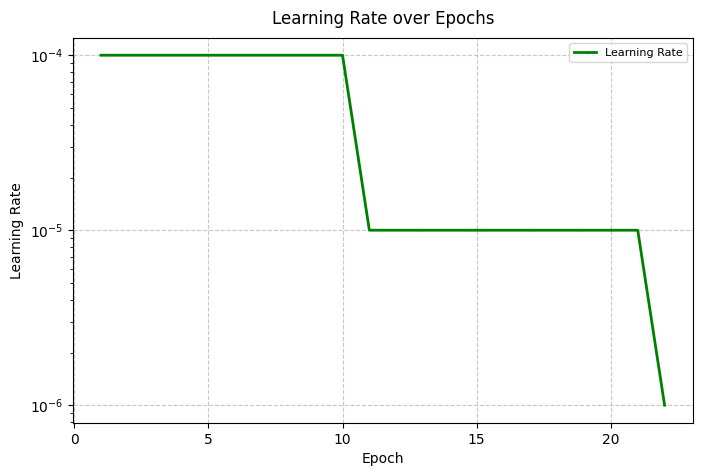


Training Metrics Summary:
Number of epochs trained: 22
Best validation loss: 0.0162 (Epoch 17)
Final validation loss: 0.0193
Best validation accuracy: 98.33%
Final validation accuracy: 98.33%

Plots saved in: resnet_model/resnet50_custom_run_1/plots/figures
- Training metrics plot: resnet_model/resnet50_custom_run_1/plots/figures/training_metrics.png
- Learning rate plot: resnet_model/resnet50_custom_run_1/plots/figures/learning_rate.png


In [22]:
# Then plot the metrics
plot_metrics(metric_1, save_dir='resnet_model/resnet50_custom_run_1/plots')

# Custom Mobilenetv2 Fine-tuning

In [ ]:
# Setup model with custom MobileNetV2 architecture and training dataset
model_2, criterion_2, optimizer_2, scheduler_2 = setup_model(
    model=MobileNetV2Custom(num_classes=config.NUM_CLASSES),
    train_dataset=train_dataset
)

In [ ]:
# Model layer summary
print(model_2)

MobileNetV2Custom(
  (base_model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kerne

In [24]:
# Train the custom MobileNetV2 model and save training metrics and the best model
metric_2, model_mobilenet = train_model(
        model_2, train_loader, val_loader, criterion_2, optimizer_2, scheduler_2,
        num_epochs=config.EPOCHS, device=config.DEVICE,
        save_dir="mobilenet_model", 
        run_name="mobilenetv2_custom_run_1"
)

Training started. Files will be saved to: mobilenet_model/mobilenetv2_custom_run_1
Early stopping settings - Patience: 5, Tolerance: 1e-06


Epoch 1/50: 100%|██████████| 8/8 [00:22<00:00,  2.78s/it]


New best model saved at epoch 1 with validation loss: 0.2033

Epoch 1/50:
Training Loss: 0.3143, Training Accuracy: 61.34%
Validation Loss: 0.2033, Validation Accuracy: 88.33%
Learning Rate: 0.000100
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 2/50: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]


New best model saved at epoch 2 with validation loss: 0.0571

Epoch 2/50:
Training Loss: 0.0826, Training Accuracy: 89.92%
Validation Loss: 0.0571, Validation Accuracy: 95.00%
Learning Rate: 0.000100
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 3/50: 100%|██████████| 8/8 [00:21<00:00,  2.71s/it]


New best model saved at epoch 3 with validation loss: 0.0544

Epoch 3/50:
Training Loss: 0.0619, Training Accuracy: 94.54%
Validation Loss: 0.0544, Validation Accuracy: 93.33%
Learning Rate: 0.000100
Early Stopping Counter: 0/5
--------------------------------------------------


Epoch 4/50: 100%|██████████| 8/8 [00:22<00:00,  2.76s/it]



Epoch 4/50:
Training Loss: 0.0578, Training Accuracy: 93.28%
Validation Loss: 0.0870, Validation Accuracy: 85.00%
Learning Rate: 0.000100
Early Stopping Counter: 1/5
--------------------------------------------------


Epoch 5/50: 100%|██████████| 8/8 [00:21<00:00,  2.71s/it]



Epoch 5/50:
Training Loss: 0.0516, Training Accuracy: 94.54%
Validation Loss: 0.1211, Validation Accuracy: 83.33%
Learning Rate: 0.000100
Early Stopping Counter: 2/5
--------------------------------------------------


Epoch 6/50: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]



Epoch 6/50:
Training Loss: 0.0441, Training Accuracy: 95.80%
Validation Loss: 0.0686, Validation Accuracy: 90.00%
Learning Rate: 0.000100
Early Stopping Counter: 3/5
--------------------------------------------------


Epoch 7/50: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]



Epoch 7/50:
Training Loss: 0.0708, Training Accuracy: 93.70%
Validation Loss: 0.0694, Validation Accuracy: 91.67%
Learning Rate: 0.000010
Early Stopping Counter: 4/5
--------------------------------------------------


Epoch 8/50: 100%|██████████| 8/8 [00:21<00:00,  2.72s/it]


Early stopping triggered after 8 epochs

[INFO] Loaded best model weights from epoch 3, val loss = 0.0544

Training Summary:
Status: early_stopped
Total Epochs Trained: 8
Best Validation Loss: 0.054408 (Epoch 3)
Final Validation Loss: 0.082188

Files saved to: mobilenet_model/mobilenetv2_custom_run_1
- Best model: mobilenet_model/mobilenetv2_custom_run_1/models/best_model.pth
- Final checkpoint: mobilenet_model/mobilenetv2_custom_run_1/models/final_checkpoint.pth
- Training metrics: mobilenet_model/mobilenetv2_custom_run_1/metrics/training_metrics.json
- Training status: mobilenet_model/mobilenetv2_custom_run_1/status/training_status.json


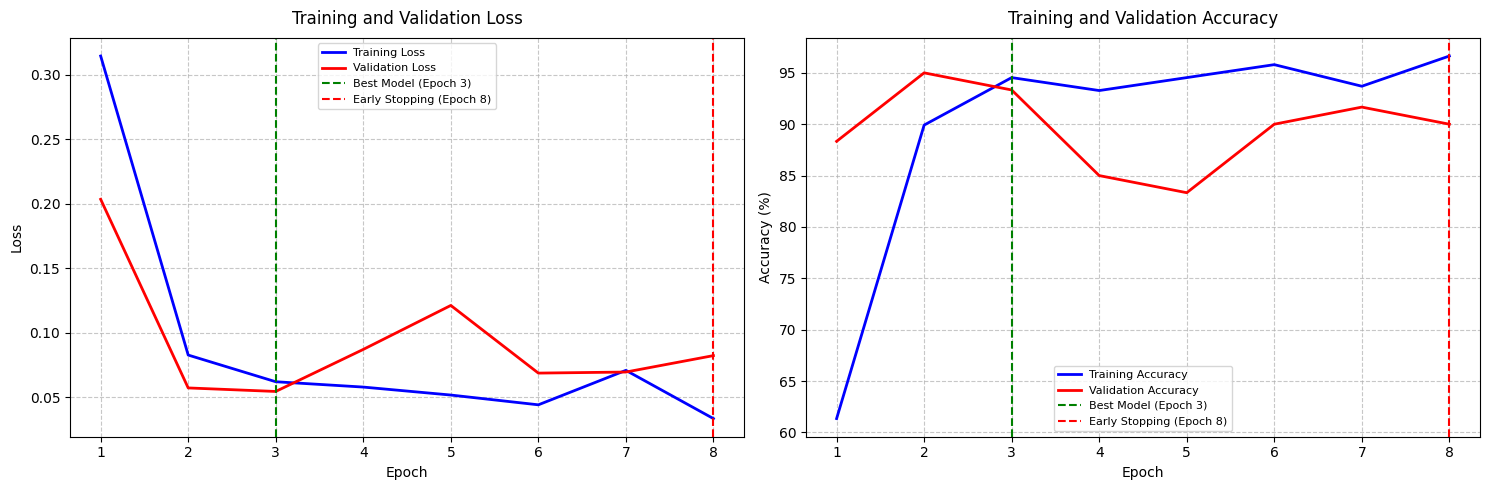

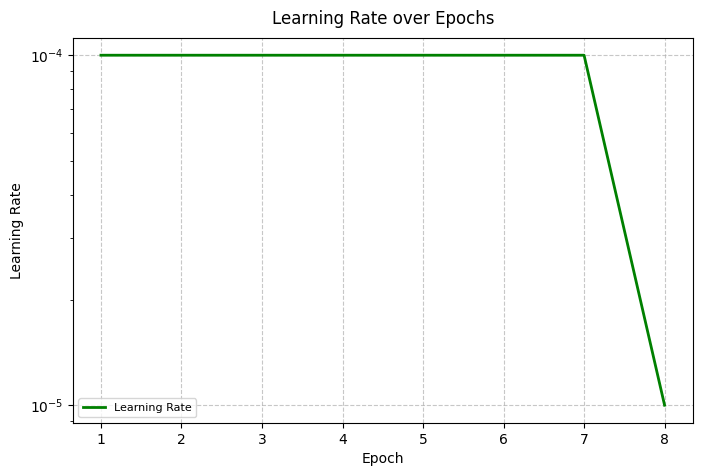


Training Metrics Summary:
Number of epochs trained: 8
Best validation loss: 0.0544 (Epoch 3)
Final validation loss: 0.0822
Best validation accuracy: 95.00%
Final validation accuracy: 90.00%

Plots saved in: mobilenet_model/mobilenetv2_custom_run_1/plots/figures
- Training metrics plot: mobilenet_model/mobilenetv2_custom_run_1/plots/figures/training_metrics.png
- Learning rate plot: mobilenet_model/mobilenetv2_custom_run_1/plots/figures/learning_rate.png


In [25]:
# Then plot the metrics
plot_metrics(metric_2, save_dir='mobilenet_model/mobilenetv2_custom_run_1/plots')

# Evaluation

- The `evaluate_predictions` function assesses model performance on a dataset.
- Calculates overall accuracy between predicted and true labels.
- Computes and prints the confusion matrix to show class-wise prediction results.
- Generates a detailed classification report (precision, recall, F1-score) for each class.
- Optionally visualizes the confusion matrix as a heatmap for easy interpretation.
- Useful for understanding strengths and weaknesses of the trained model.

In [ ]:
def predict(model, data_loader, device='cuda'):
    """
    Generate predictions and probabilities for a given model and data loader.

    Args:
        model: Trained PyTorch model.
        data_loader: DataLoader for the dataset to predict.
        device: Device to run inference on ('cuda', 'cpu', etc.).

    Returns:
        predictions: List of predicted class indices.
        probabilities: List of softmax probability arrays for each sample.
        true_labels: List of true class indices.
    """
    model.eval()  # Set model to evaluation mode
    predictions, probabilities, true_labels = [], [], []
    with torch.no_grad():  # Disable gradient computation for inference
        for inputs, labels in tqdm(data_loader, desc='Predicting'):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Get class probabilities
            _, preds = torch.max(outputs, 1)       # Get predicted class indices
            predictions.extend(preds.cpu().numpy())
            probabilities.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return predictions, probabilities, true_labels



In [39]:
def evaluate_predictions(predictions, true_labels, class_names=None):
    """
    Evaluate predictions using accuracy, confusion matrix, and classification report.
    Optionally display a heatmap of the confusion matrix.

    Args:
        predictions (list or np.array): Predicted class indices.
        true_labels (list or np.array): True class indices.
        class_names (list, optional): List of class names for display.
    """
    # Convert to numpy arrays for compatibility
    predictions = np.array(predictions)
    true_labels = np.array(true_labels)
    
    # Calculate accuracy
    accuracy = accuracy_score(true_labels, predictions)
    
    # Compute confusion matrix
    conf_matrix = confusion_matrix(true_labels, predictions)
    
    # Generate classification report
    classification_rep = classification_report(true_labels, predictions, target_names=class_names)
    
    # Print metrics
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    print("\nClassification Report:\n", classification_rep)
    
    # Plot confusion matrix as heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Validation Confusion Matrix')
    plt.show()


## Custom  Resnet50

In [28]:
preds, probs, true_labels = predict(model_resnet, val_loader, device=config.DEVICE)



Predicting: 100%|██████████| 2/2 [00:11<00:00,  5.78s/it]



Accuracy: 0.9833

Confusion Matrix:
 [[15  0  0]
 [ 1 24  0]
 [ 0  0 20]]

Classification Report:
               precision    recall  f1-score   support

        None       0.94      1.00      0.97        15
        back       1.00      0.96      0.98        25
       front       1.00      1.00      1.00        20

    accuracy                           0.98        60
   macro avg       0.98      0.99      0.98        60
weighted avg       0.98      0.98      0.98        60



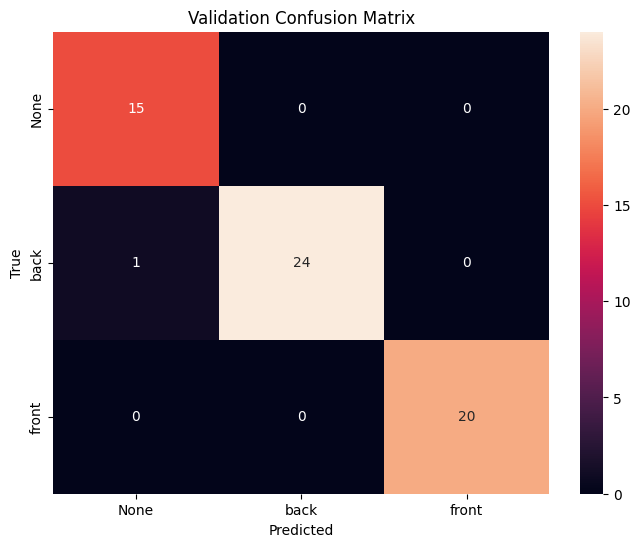

In [40]:
evaluate_predictions(preds, true_labels, class_names=config.CLASSES)

## Custom Mobilenetv2

In [30]:
preds_1, probs_1, true_labels_1 = predict(model_mobilenet, val_loader, device=config.DEVICE)

Predicting: 100%|██████████| 2/2 [00:11<00:00,  5.72s/it]



Accuracy: 0.9333

Confusion Matrix:
 [[15  0  0]
 [ 2 23  0]
 [ 0  2 18]]

Classification Report:
               precision    recall  f1-score   support

        None       0.88      1.00      0.94        15
        back       0.92      0.92      0.92        25
       front       1.00      0.90      0.95        20

    accuracy                           0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60



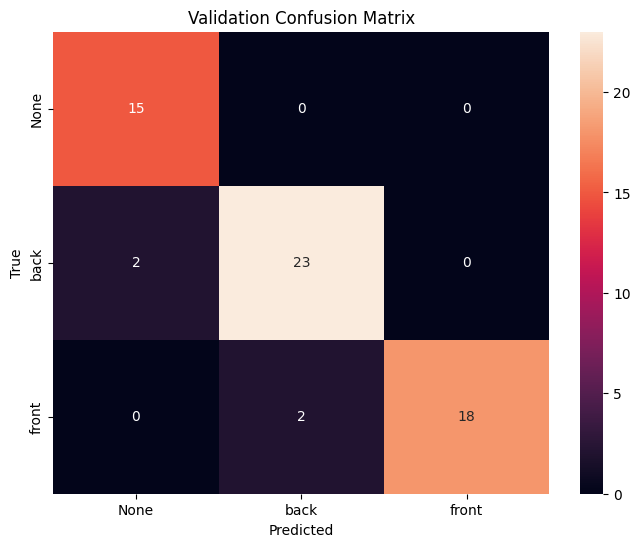

In [41]:
evaluate_predictions(preds_1, true_labels_1, class_names=config.CLASSES)